In [30]:
import matplotlib.pyplot as plt
import numpy as np
#import numpy singular value decomposition
import numpy.linalg as la
import math
import cmath 
import contfrac
from MPS_old import *
xi = 2**8

In [11]:
#get random complex numpy vector
def get_random_complex_vector(shape):
    return np.random.rand(shape) + 1j*np.random.rand(shape)



In [12]:
#Define all Gates
CNOT = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]).reshape(2,2,2,2)
H = np.array([[1,1],[1,-1]]).reshape(2,2)/np.sqrt(2)
SWAP = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).reshape(2,2,2,2)
def R(k,inv=False): 
    return np.array([[1,0,0,0],
                    [0,1,0,0],
                    [0,0,1,0],
                    [0,0,0,cmath.exp((-1)**inv * 1j*2*math.pi/(2**k))]]).reshape([2,2,2,2])
#Merge 2 2 site gate to 1 2 site gate
def merge_gate(gate1,gate2):
    #Check if gate1 and gate2 are 2 site gates
    #print_tensor(gate1,"gate1")
    #print_tensor(gate2,"gate2")
    return np.tensordot(gate1,gate2,[[2,3],[0,1]])



In [13]:
#Fourier transform MPS
def fourier_transform_MPS(MPS,inv=False,revbit_order=True):
    L = len(MPS)//2
    for i in range(L):
        apply_gate_1(MPS,H,0)
        for j in range(L-i-1):
            mgate = merge_gate(R(j,inv),SWAP)
            apply_gate_2(MPS,mgate,j,xi)
    if revbit_order:
        MPS = reverse_bit_order_MPS(MPS)
    return MPS

In [14]:
#Construction of the U Matrix
def get_U_matrices(N,x,bitlength_register_A,bitlength_register_B):
    L = bitlength_register_B
    U = np.zeros((2**L,2**L))
    for i in range(2**L):
        if(i<N):
            U[(i*x)%N,i] = 1
        else:
            U[i,i]=1

    Upow2k= np.zeros((2**L,2**L,bitlength_register_A))
    Upow2k[:,:,0]=U[:,:]
    for i in range(1,bitlength_register_A):
        Upow2k[:,:,i]=np.tensordot(Upow2k[:,:,i-1],Upow2k[:,:,i-1],axes=(1,0))
    return Upow2k

def get_CU_matrices(N,x,bitlength_register_A,bitlength_register_B):
    Upow2k = get_U_matrices(N,x,bitlength_register_A,bitlength_register_B)
    L = bitlength_register_B
    CUpow2k=np.zeros((2**(L+1),2**(L+1),bitlength_register_A))
    for i in range(bitlength_register_A):
        CUpow2k[0:2**L,0:2**L,i]=np.identity(2**L)
        CUpow2k[2**L:2**(L+1),2**L:2**(L+1),i]=Upow2k[:,:,i]
    return CUpow2k


In [15]:
# Random Circuit
"""
N=24
xi = 2**8

MPS = create_MPS(N)
MPS[1] = np.array([[[0],[1]]],dtype="complex")

def get_random_U_gate():
    phi = np.random.uniform(0,2*np.pi)
    v = np.random.rand(2)+1j*np.random.rand(2)
    v = v/la.norm(v)
    U = np.array([[v[0],v[1]],
                  [-np.conj(v[1])*np.exp(1j*phi),np.exp(1j*phi)*np.conj(v[0])]])
    #print(np.matmul(U,np.conj(U.T)))
    return U

depth = 100 #Number of layers
for i in range(depth):
    for j in range(N):
        apply_gate_1(MPS,get_random_U_gate(),j)
        #print(j)
    k = i%2
    for j in range(k,N-k-1,2):
        apply_gate_2(MPS,CNOT,j,xi)
    #plot_bond_dimensions(MPS)
    if i%10==0:
        print(i)
        print_all_bond_norms(MPS)
        plot_schmidt_values(MPS)
        plot_bond_dimensions(MPS)

print_total_probability_MPS(MPS)



#Test if schmidt decomposition works
A1 = np.tensordot(MPS[0],MPS[1],axes=([0],[0]))
print_shape(A1,"A1")
print(np.tensordot(A1,np.conj(A1.T),axes=([1],[0])))
print_all_shapes(MPS)

A2 = np.tensordot(MPS[2],MPS[3],axes=([1],[0]))
print_shape(A2,"A2")
A2 = np.tensordot(A2,np.conj(A2),axes=([0,1],[0,1]))
print(A2)
print_shape(A2,"A2") """


'\nN=24\nxi = 2**8\n\nMPS = create_MPS(N)\nMPS[1] = np.array([[[0],[1]]],dtype="complex")\n\ndef get_random_U_gate():\n    phi = np.random.uniform(0,2*np.pi)\n    v = np.random.rand(2)+1j*np.random.rand(2)\n    v = v/la.norm(v)\n    U = np.array([[v[0],v[1]],\n                  [-np.conj(v[1])*np.exp(1j*phi),np.exp(1j*phi)*np.conj(v[0])]])\n    #print(np.matmul(U,np.conj(U.T)))\n    return U\n\ndepth = 100 #Number of layers\nfor i in range(depth):\n    for j in range(N):\n        apply_gate_1(MPS,get_random_U_gate(),j)\n        #print(j)\n    k = i%2\n    for j in range(k,N-k-1,2):\n        apply_gate_2(MPS,CNOT,j,xi)\n    #plot_bond_dimensions(MPS)\n    if i%10==0:\n        print(i)\n        print_all_bond_norms(MPS)\n        plot_schmidt_values(MPS)\n        plot_bond_dimensions(MPS)\n\nprint_total_probability_MPS(MPS)\n\n\n\n#Test if schmidt decomposition works\nA1 = np.tensordot(MPS[0],MPS[1],axes=([0],[0]))\nprint_shape(A1,"A1")\nprint(np.tensordot(A1,np.conj(A1.T),axes=([1],[0]))

In [16]:
#Try Fourer transform

"""
L = 3
MPS = create_MPS(L)

PSI = MPS_to_PSI(MPS)
plot_psi(PSI,[i for i in range(L)])

fourier_transform_MPS(MPS)
PSI = MPS_to_PSI(MPS)
plot_psi(PSI,[i for i in range(L)])
plot_psi_as_barchart(PSI)


fourier_transform_MPS(MPS,inv=True)
PSI = MPS_to_PSI(MPS)
plot_psi(PSI,[i for i in range(L)])
print_amplitudes(PSI)
"""


'\nL = 3\nMPS = create_MPS(L)\n\nPSI = MPS_to_PSI(MPS)\nplot_psi(PSI,[i for i in range(L)])\n\nfourier_transform_MPS(MPS)\nPSI = MPS_to_PSI(MPS)\nplot_psi(PSI,[i for i in range(L)])\nplot_psi_as_barchart(PSI)\n\n\nfourier_transform_MPS(MPS,inv=True)\nPSI = MPS_to_PSI(MPS)\nplot_psi(PSI,[i for i in range(L)])\nprint_amplitudes(PSI)\n'

(128, 128, 15)


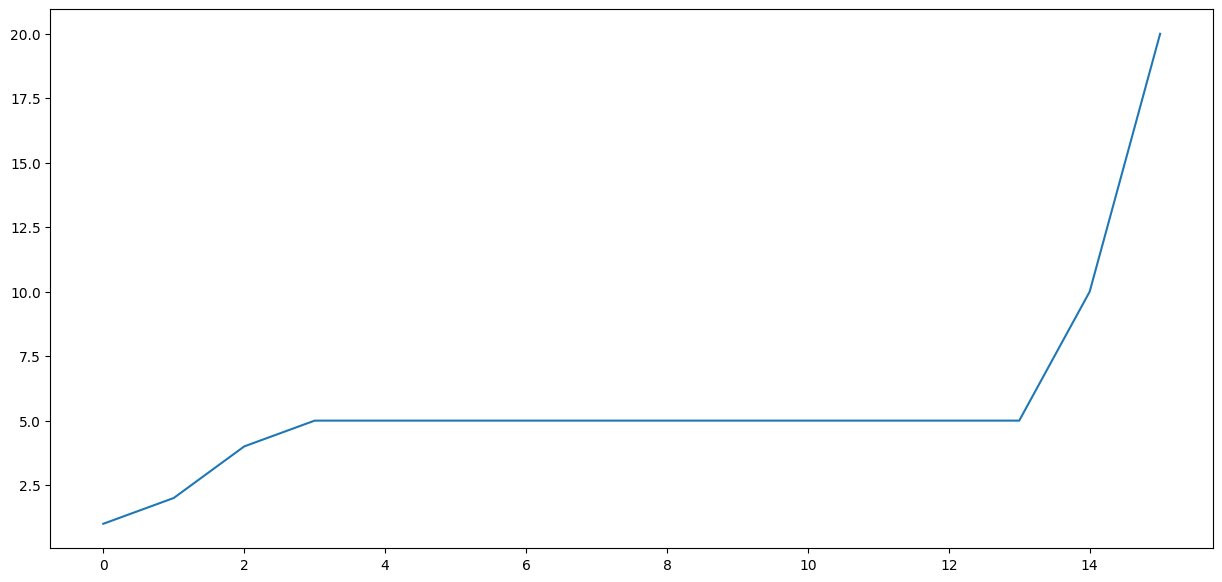

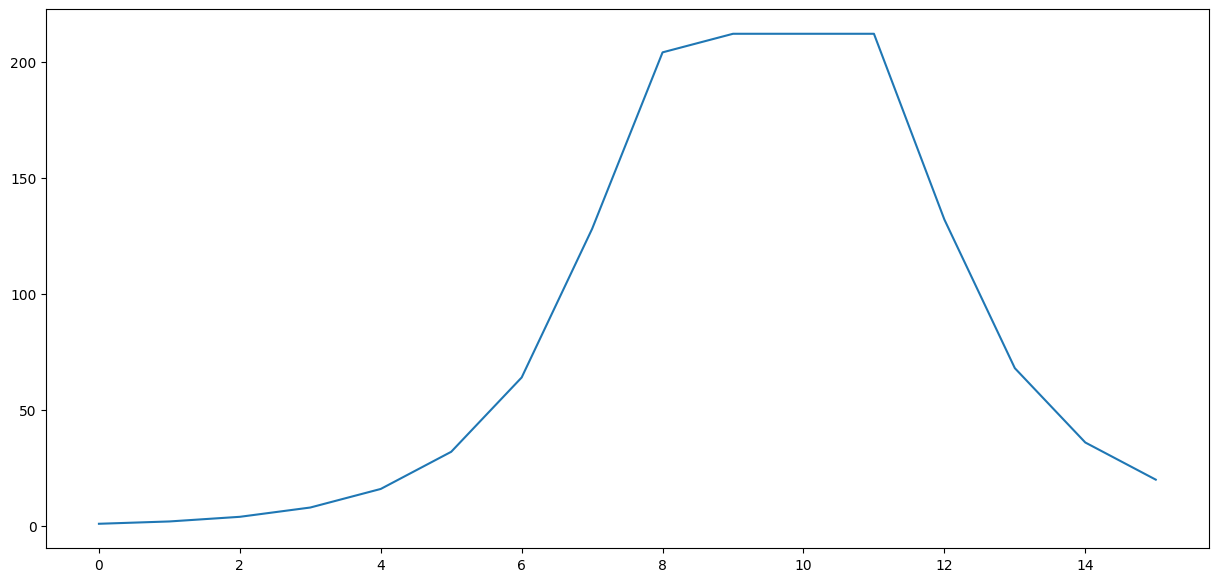

/home/xkainz/.local/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


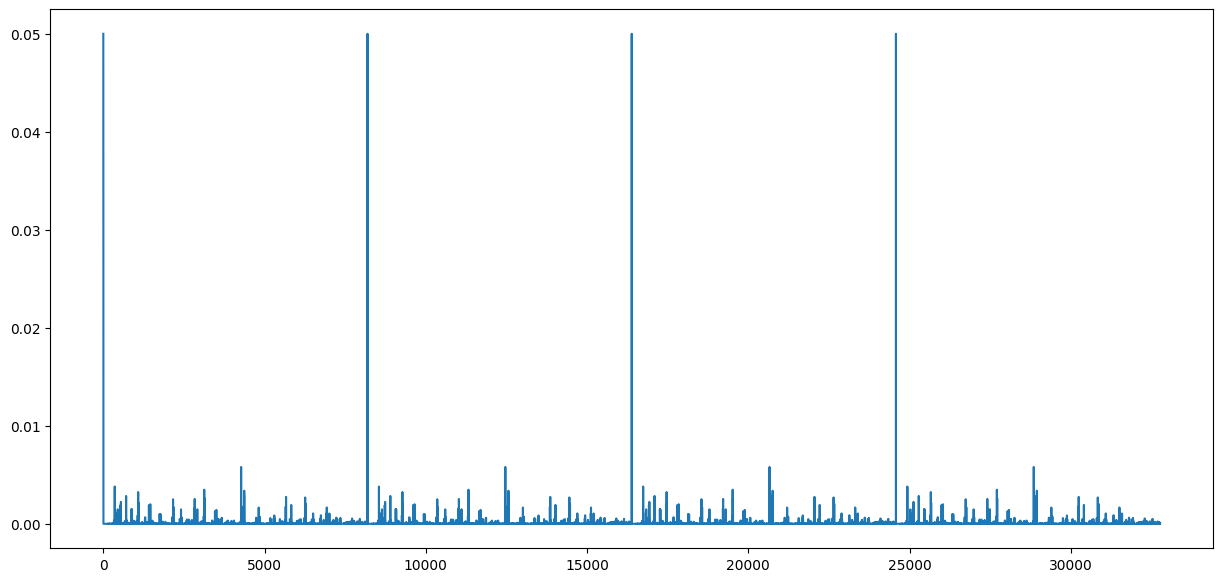

In [17]:
#Quantum Part of Shor's algorithm

#Try quantum Part of Shor's algorithm
N = 11*5
x=7
L = len(format(N,'b'))

#Create First Register in MPS
bitlength_register_A = 2*L+3
MPS = create_MPS(bitlength_register_A)
MPS[1] = np.array([[[0],[1]]],dtype="complex")
MPS[-1] = np.reshape(MPS[-1],(1,)*2)


#Create Second Register 
bitlength_register_B = L
Register_2 = np.zeros(2**bitlength_register_B,dtype="complex")
Register_2[1]=1 #Initialize at |1>
Register_2 = np.reshape(Register_2,(1,)+(2,)*bitlength_register_B)

#Apply Hadamard gate to all sites of first register
for i in range(bitlength_register_A):
    apply_gate_1(MPS,H,i)

psi = MPS_to_PSI(MPS+[Register_2])

#plot_bond_dimensions(MPS)

#plot_psi(MPS_to_PSI(MPS),[i for i in range(bitlength_register_A)])

CU_matrices = get_CU_matrices(N,x,bitlength_register_A,bitlength_register_B)
print(CU_matrices.shape)

for i in range(bitlength_register_A):
    CU = np.reshape(CU_matrices[:,:,bitlength_register_A-i-1],(2,)*(2*(L+1)))
    Register_2 = apply_U_gate(MPS,Register_2,CU,xi)
    for j in range(bitlength_register_A-2,i-1,-1):
        apply_gate_2(MPS,SWAP,j,xi)

psi = MPS_to_PSI(MPS+[Register_2])

plot_bond_dimensions(MPS)

fourier_transform_MPS(MPS,True,False)

plot_bond_dimensions(MPS)

psi = MPS_to_PSI(MPS+[Register_2])
psi = np.reshape(psi,(2,)*(len(psi.shape)-1))
mpsi = measure_subspace_psi(psi,[*range(bitlength_register_A)]).flatten()
plt.figure(figsize=(15,7))
plt.plot([*range(0,2**bitlength_register_A)],mpsi)
plt.show()






    




In [18]:
#Implementation of sampling from a MPS


#vector of zeros and ones to number
def v2n(v):
    n = 0
    for i in range(len(v)):
        n += 2**i*v[len(v)-1-i]
    return n



#take 10000 samples and plot them
sample_number = 1000
samples = [0]*sample_number
for i in range(sample_number):
    samples[i] = v2n(sample_MPS(MPS))

#count occurences of each number
counts = [0]*2**(len(sample_MPS(MPS)))
for i in range(sample_number):
    counts[samples[i]] += 1

print(counts, sum(counts), "counts")


plt.figure(figsize=(15,7))
plt.plot(counts)
plt.show()

psi = MPS_to_PSI(MPS+[Register_2,])
psi = np.reshape(psi,(2,)*(len(psi.shape)-1))
mpsi = measure_subspace_psi(psi,[*range(bitlength_register_A)]).flatten()
plt.figure(figsize=(15,7))
plt.plot([*range(0,2**bitlength_register_A)],mpsi)
plt.show()






KeyboardInterrupt: 

(1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2) psi shape
(1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1)


/home/xkainz/.local/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


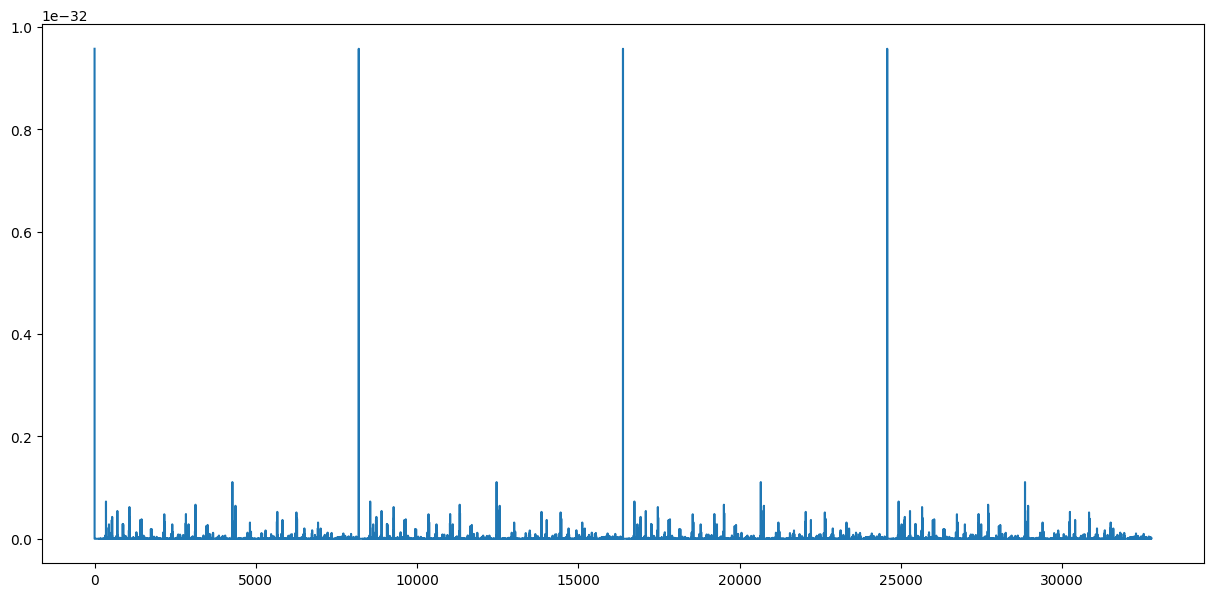

In [44]:



psi = MPS_to_PSI(MPS+[Register_2,])
MPSnew = to_MPS(psi,2**8,cutoff = 1e-8)
psi = MPS_to_PSI(MPSnew)
print(psi.shape)


psi = np.reshape(psi,(2,)*(len(psi.shape)-2))
mpsi = measure_subspace_psi(psi,[*range(bitlength_register_A)]).flatten()
plt.figure(figsize=(15,7))
plt.plot([*range(0,2**bitlength_register_A)],mpsi)
plt.show()
#plot_bond_dimensions(MPSnew)



In [ ]:

#get index of largest element
index = np.argsort(mpsi,axis=0)[-2]
value = (index,2**bitlength_register_A)
print("value")
print(value)
convergents = list(contfrac.convergents(value))
print(convergents)

def get_largest_convergent_within_range(N,convergents):
    for i in convergents:
        if i[1] > N:
            return j[1]
        j = i
    return j[1]

r = get_largest_convergent_within_range(N,convergents)
print(r)

print("gcd(x**r//2-1)="+str(math.gcd(x**(r//2)-1,N)))
print("gcd(x**r//2+1)="+str(math.gcd(x**(r//2)+1,N)))




value
(8192, 32768)
[(0, 1), (1, 4)]
4
gcd(x**r//2-1)=1
gcd(x**r//2+1)=5
